# Using skorch

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import seaborn as sb
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
%matplotlib inline
torch.__version__

from itertools import islice
from sklearn.model_selection import train_test_split

In [2]:
BATCH_SIZE = 64
EPOCHS = 60
DEVICE_NUM = 1
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0
torch.manual_seed(10)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(DEVICE_NUM)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Read Data

In [4]:
import numpy as np
import pandas as pd
import os
import struct

In [5]:
train_images = np.load("train.npy")
test_images = np.load("test.npy")

In [6]:
train_labels_df = pd.read_csv("train.csv")
train_labels = train_labels_df["label"].to_numpy()
train_labels.shape

(30000,)

In [7]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [5]:
data_path = "./"
train_images_ex, train_labels_ex  = load_mnist(data_path, kind="train")
test_images_ex, test_labels_ex  =  load_mnist(data_path, kind="t10k")

train_images_ex = np.concatenate((train_images_ex,test_images_ex),axis=0)
train_labels_ex = np.concatenate((train_labels_ex,test_labels_ex),axis=0)

train_images = np.concatenate((train_images_ex,train_images),axis=0)
train_labels = np.concatenate((train_labels_ex,train_labels),axis=0)

In [6]:
train_images.shape

(100000, 784)

In [7]:
train_labels.shape

(100000,)

In [8]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(train_images,train_labels,test_size=0.05, random_state=0)

In [8]:
submission = pd.read_csv("samplesummission.csv")
submission

,image_id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


## Img Save

In [10]:
# from PIL import Image
# from skimage import color
# from skimage.morphology import disk
# import skimage.filters.rank as sfr

# for i in range(10):
#     path = "./data/train/"+str(i)
#     if not os.path.exists(path):
#         os.mkdir(path)
#     path = "./data/val/"+str(i)
#     if not os.path.exists(path):
#         os.mkdir(path)
        
# path = "./data/test/"+str(0)
# if not os.path.exists(path):
#     os.mkdir(path)


# for index,A in enumerate(train_images):
#     A = A.reshape(28,28)
#     A = sfr.median(A, disk(1))
#     img = Image.fromarray(A)
#     img.save("./data/train/"+str(train_labels[index])+"/"+str(index)+".jpg")
    
# for index,A in enumerate(val_images):
#     A = A.reshape(28,28)
#     A = sfr.median(A, disk(1))
#     img = Image.fromarray(A)
#     img.save("./data/val/"+str(val_labels[index])+"/"+str(index)+".jpg")

# for index,A in enumerate(test_images):
#     A = A.reshape(28,28)
#     A = sfr.median(A, disk(1))
#     img = Image.fromarray(A)
#     if index < 10:
#         img.save("./data/test/"+str(0)+"/000"+str(index)+".jpg")
#     elif index < 100:
#         img.save("./data/test/"+str(0)+"/00"+str(index)+".jpg")
#     elif index < 1000:
#         img.save("./data/test/"+str(0)+"/0"+str(index)+".jpg")
#     else:
#         img.save("./data/test/"+str(0)+"/"+str(index)+".jpg")

## Data Loader

In [9]:
data_dir = '/home/yj-dyj/AI_homework/data'
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'train'), train_transforms)
val_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'val'), val_transforms)
test_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'test'), test_transforms)

## Define Model

In [10]:
class Net(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet34(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [11]:
from skorch.callbacks import LRScheduler

lrscheduler = LRScheduler(
    policy='StepLR', step_size=10, gamma=0.05)

from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(
    f_params='best_model.pt', monitor='valid_acc_best')
    
# from skorch.callbacks import Freezer

# freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [12]:
net = NeuralNetClassifier(
    Net, 
    criterion=nn.CrossEntropyLoss,
    lr=LR,
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    module__output_features=10,
    optimizer=optim.SGD,
    optimizer__momentum=MOMENTUM,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=True,
    iterator_valid__num_workers=4,
    callbacks=[lrscheduler, checkpoint],
    train_split=predefined_split(val_ds),
    device=DEVICE
)

## Train Model

In [11]:
net.fit(train_ds, y=None)

  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        0.3711       0.9086        0.2464     +  292.6983
      2        0.2509       0.9032        0.2670        222.6787
      3        0.2187       0.9208        0.2111     +  226.9561
      4        0.1968       0.9306        0.1914     +  222.4645
      5        0.1818       0.9250        0.2071        223.3307
      6        0.1683       0.9328        0.1789     +  221.8302
      7        0.1567       0.9384        0.1642     +  221.2316
      8        0.1476       0.9292        0.1908        221.5709
      9        0.1371       0.9316        0.1990        221.5526
     10        0.1288       0.9370        0.1716        221.0359
     11        0.1228       0.9272        0.2017        220.7543
     12        0.0814       0.9514        0.1532     +  224.1046
     13        0.0674       0.9508        0.1553        221.8014
     14        0.0623    

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

## Predict

In [13]:
val_loader = DataLoader(dataset=val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
model = Net(10).to(DEVICE)
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [15]:
model.eval()
correct = 0
total = 0
for images, labels in val_loader:
    labels = torch.squeeze(labels)
    images = images.type(torch.FloatTensor).to(DEVICE)
    with torch.no_grad():
        outputs =  model(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('验证集上准确率: %.4f %%' % (100 * correct / total))

验证集上准确率: 95.0000 %


In [16]:
model.eval()
res = np.array([])
res.dtype = np.int64
for images, labels in test_loader:
    images = images.type(torch.FloatTensor).to(DEVICE)
    with torch.no_grad():
        outputs = model(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    res = np.concatenate((res,predicted))

In [17]:
res_df = pd.DataFrame(res)
submission["label"] = res_df
submission

,image_id,label
0,0,7
1,1,6
2,2,4
3,3,8
4,4,1
...,...,...
4995,4995,2
4996,4996,5
4997,4997,3
4998,4998,7


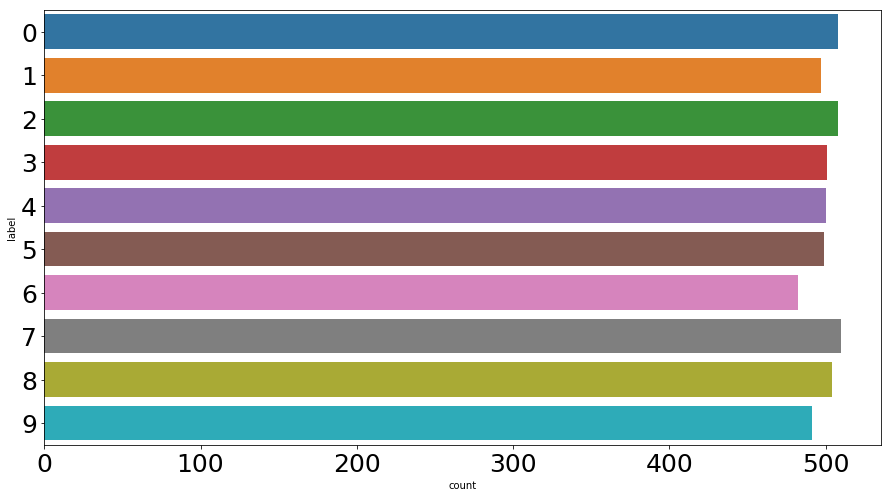

In [18]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(15,8))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
sb.countplot(y='label', data=submission)

## Save Result

In [19]:
submission.to_csv("transfer.csv",index=0)